## This compares to DoubleBracketIteration whenever possible

In [4]:
import inspect
import sys
sys.path.append("../../tests")
from test_models_dbi import *
def print_function_source_code( func ):
    out = inspect.getsourcelines(func)  
    from functools import reduce
    print(reduce(str.__add__, out[0]))

In [5]:
t_step =0.1
eps = 1e-2
import qibo
backend = qibo.backends.construct_backend("numpy")
qibo.set_backend("numpy")
nqubits = 3

[Qibo 0.2.7|INFO|2024-04-06 09:40:21]: Using numpy backend on /CPU:0


In [6]:
from numpy.linalg import norm
h_x = SymbolicHamiltonian( symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) 
                          + symbols.Y(1) * symbols.Y(2), nqubits = 3 )
d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits = 3 )
h_input = h_x + d_0 

dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.single_commutator


dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2.mode = DoubleBracketGeneratorType.group_commutator

V_dbi = dbi.eval_dbr_unitary(t_step, d=d_0.dense.matrix)
R_dbi = dbi2.eval_dbr_unitary(t_step, d=d_0.dense.matrix)

evolution_oracle = EvolutionOracle(h_input, "ZX",
                    mode_evolution_oracle = EvolutionOracleType.numerical)    

evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
           mode_evolution_oracle = EvolutionOracleType.numerical)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
#gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator

unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step), evolution_oracle_diagonal_target )   
Q_gci = unitary_gc_from_oracles['forwards']

assert norm(Q_gci.conj().T - unitary_gc_from_oracles['backwards']) < 1e-12

h0_norm = np.linalg.norm(h_x.dense.matrix)
d0_norm = np.linalg.norm(d_0.dense.matrix)
assert norm(V_dbi - R_dbi) < 2 *t_step**1.49 * ( h0_norm + d0_norm ) * h0_norm * d0_norm

[Qibo 0.2.7|WARNING|2024-04-06 09:40:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-06 09:40:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-06 09:40:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


9.664636718428507e-16
0.0
0.0
9.664636718428507e-16
start
8.570566018546674e-16 2.069502835539648e-18
None 7.102648668054811e-16
None 2.069502835539648e-18
stop
[[ 4.02235598e-01-0.29764673j -2.53495292e-01+0.18758172j
  -7.96539477e-02-0.15421646j  3.51159382e-01+0.5130534j
  -6.64615932e-17-0.31397323j  3.23092247e-17+0.25955811j
   1.35752717e-01+0.04415144j  2.15406665e-01-0.02782494j]
 [ 2.53495292e-01-0.18758172j  4.02235598e-01-0.29764673j
  -3.51159382e-01-0.5130534j  -7.96539477e-02-0.15421646j
   0.00000000e+00-0.25955811j -3.55618313e-17-0.31397323j
  -2.15406665e-01+0.02782494j  1.35752717e-01+0.04415144j]
 [-3.51159382e-01-0.5293799j  -7.96539477e-02-0.08224007j
   4.02235598e-01-0.29764673j -2.53495292e-01+0.18758172j
  -1.35752717e-01+0.04415144j -2.15406665e-01-0.02782494j
  -2.68882139e-17-0.36962312j -1.14925430e-17+0.17125522j]
 [ 7.96539477e-02+0.08224007j -3.51159382e-01-0.5293799j
   2.53495292e-01-0.18758172j  4.02235598e-01-0.29764673j
   2.15406665e-01+0.027824

In [7]:
norm(Q_gci.conj().T - R_dbi )

1.9045740584321311

In [8]:
norm(Q_gci - R_dbi )

1.051669878291704

In [9]:
from scipy.linalg import expm

s_step = np.sqrt(t_step)
Vh = expm(1j * s_step * h_input.dense.matrix )

Vd = expm(1j * s_step * d_0.dense.matrix )

In [10]:
norm( Vh @ Vd @ Vh.conj().T @ Vd.conj().T - R_dbi)

5.716110830818201e-16

In [11]:
norm( Vh @ Vd @ Vh.conj().T @ Vd.conj().T - Q_gci)

1.0516698782917042

In [12]:
norm( Vh - evolution_oracle.circuit(-s_step))

0.0

In [13]:
norm( Vd - evolution_oracle_diagonal_target.circuit(-s_step))

0.0

In [14]:
norm( Vd.conj().T - evolution_oracle_diagonal_target.circuit(s_step))

0.0

In [15]:
norm( Vh.conj().T - evolution_oracle.circuit(s_step))

5.103534121246274e-16

In [16]:
from functools import reduce
S = reduce(np.ndarray.__matmul__,[ Vh,Vd,Vh.conj().T, Vd.conj().T])

In [17]:
norm(S- Q_gci)

1.0516698782917042

In [ ]:
norm(S- R_dbi)

In [ ]:
norm( Vh - gci.iterated_hamiltonian_evolution_oracle.circuit(-s_step))

In [19]:
self =gci
eo1 = evolution_oracle_diagonal_target
eo2 = evolution_oracle
s_step = np.sqrt(t_step)

if eo2 is None:
    eo2 = self.iterated_hamiltonian_evolution_oracle
##
from scipy.linalg import expm, norm

Vh = expm(1j * s_step * eo2.h.dense.matrix )
Vd = expm(1j * s_step * eo1.h.dense.matrix )
#  print(norm( Vh @ Vd @ Vh.conj().T @ Vd.conj().T - super().eval_dbr_unitary(t_step,d = eo1.h.dense.matrix)))
print(norm( Vh - eo2.circuit(-s_step)))
print(norm( Vd - eo1.circuit(-s_step)))
from functools import reduce
by_hand_list = [ Vh,Vd,Vh.conj().T, Vd.conj().T]
S = reduce(np.ndarray.__matmul__,by_hand_list)
#  print(norm( S - super().eval_dbr_unitary(t_step,d = eo1.h.dense.matrix)))
assert eo1.mode_evolution_oracle.value is eo2.mode_evolution_oracle.value

eo_mode = eo1.mode_evolution_oracle


gc_type = self.mode_double_bracket_rotation


if gc_type is DoubleBracketRotationType.single_commutator:
    raise_error(
        ValueError,
        "You are trying to get the group commutator query list but your dbr mode is single_commutator and not an approximation by means of a product formula!",
    )

if gc_type is DoubleBracketRotationType.group_commutator:  
    query_list_forward = [ eo2.circuit(-s_step), eo1.circuit(-s_step), eo2.circuit(s_step), eo1.circuit(s_step) ]
    query_list_backward = [ eo1.circuit(-s_step), eo2.circuit(-s_step), eo1.circuit(s_step), eo2.circuit(s_step) ]
elif gc_type is DoubleBracketRotationType.group_commutator_reduced:  
    query_list_forward = [ eo1.circuit(s_step), eo2.circuit(s_step), eo1.circuit(-s_step) ]
    query_list_backward = [ eo1.circuit(s_step), eo2.circuit(-s_step), eo1.circuit(-s_step) ] 
else:
    raise_error(
        ValueError,
        "You are in the group commutator query list but your dbr mode is not recognized",
    )
print("start")
reduce( print, [norm(x @ y.conj().T -np.eye(x.shape[0])) for x,y in zip( query_list_forward,by_hand_list)]) 
from functools import reduce
print("stop")
for x,y in zip( query_list_forward,by_hand_list):
    print(norm(x @ y.conj().T -np.eye(x.shape[0])))

A = reduce(np.ndarray.__matmul__, query_list_forward)
B = reduce(np.ndarray.__matmul__, by_hand_list)
norm(A-B)

0.0
0.0
start
7.516933549631155e-16 6.149486291803641e-17
None 4.665547176382431e-16
None 6.149486291803641e-17
stop
7.516933549631155e-16
6.149486291803641e-17
4.665547176382431e-16
6.149486291803641e-17


5.716110830818201e-16

In [24]:
norm(R_dbi- V_dbi)

1.0136811088581048

In [18]:
if eo_mode is EvolutionOracleType.text_strings:
    return {
        "forwards": reduce(str.__add__, query_list_forward),
        "backwards": reduce(str.__add__, query_list_backward),
    }
elif eo_mode is EvolutionOracleType.hamiltonian_simulation:
    return {
        "forwards": reduce(Circuit.__add__, query_list_forward[::-1]),
        "backwards": reduce(Circuit.__add__, query_list_backward[::-1]),
    }
elif eo_mode is EvolutionOracleType.numerical:
    return {
            "forwards": reduce(np.ndarray.__matmul__, query_list_forward),
            "backwards": reduce(np.ndarray.__matmul__, query_list_backward)
        }
else:
    raise_error(ValueError, "Your EvolutionOracleType is not recognized")

group_commutator(gci, t_step, eo1 = evolution_oracle_diagonal_target)

0.0
0.0
start
7.516933549631155e-16 6.149486291803641e-17
None 4.665547176382431e-16
None 6.149486291803641e-17
stop
7.516933549631155e-16
6.149486291803641e-17
4.665547176382431e-16
6.149486291803641e-17


SyntaxError: 'return' outside function (1962676161.py, line 57)

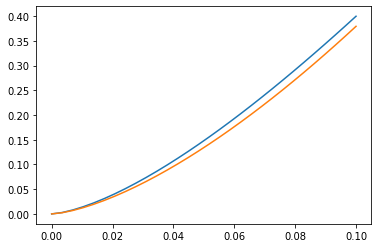

In [44]:
dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.single_commutator


dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2.mode = DoubleBracketGeneratorType.group_commutator


norms = []
norms2 = []
for s in np.linspace(1e-5,.1,30):
    V_dbi = dbi.eval_dbr_unitary(s, d=d_0.dense.matrix)
    R_dbi = dbi2.eval_dbr_unitary(s, d=d_0.dense.matrix)
    norms.append(norm(V_dbi.conj().T-R_dbi))
    norms2.append(norm(V_dbi-R_dbi))
import matplotlib.pyplot as plt  
plt.plot(np.linspace(1e-5,.1,30),norms)
plt.plot(np.linspace(1e-5,.1,30), [x**1.5*12 for x in np.linspace(1e-5,.1,30)])

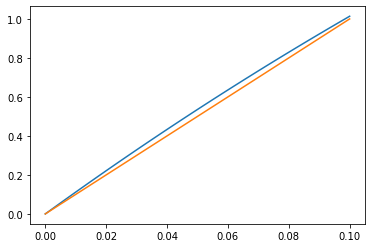

In [50]:
plt.plot(np.linspace(1e-5,.1,30),norms2)
plt.plot(np.linspace(1e-5,.1,30), [x*10 for x in np.linspace(1e-5,.1,30)])